# <center> IEDA3302 Project </center>

<h4>
<table align = "right">
<tr>
<td> Name:</td>
<td> SID:</td>
</tr>
<tr>
<td> Tsang Chun Lung</td>
<td> 20692823</td>
</tr>
<tr>
<td> Yan Tsz Ching</td>
<td> 123</td>
</tr>
<tr>
<td> Joseph </td>
<td> 123</td>
</tr>
</table>
</h4>

<h4>


Background: Nowadays, E-commerce has been a key driver to the success of business intelligence. However, what price should the product to be set for is a concern. Data analysis according to the data collected from the internet would be helpful. For that , we are going to conduct data analysis on the data collected from one of the most famous E-commerce platform - HKTV Mall<br>

Objective: To find out the spending price according to different parameters including gender, age and product category <br>
From this project, the different stages of the code would be:
<ol>
<li>Introduction</li>
<li>Import of data and Data Preprocessing</li>
<li>Dimension Reduction</li>
<li>Regression</li>
<li>KNN Classifier</li>
<li>Support Vector Machine</li>
<li>Decision Tree</li>
<li>Conclusion of the analysis</li>
</ol>

</h4>

# Import of data and Data preprocessing <hr>
This part is done by Juno.<br>
First we create an account from HKTV Mall Opensource Databank and take the transaction data from November, 2021 to November, 2022, each month's first day as the data. <br>
Then we also use the user data API to get the information of user and merge it together with the transaction.

In [2]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

### Data we going to use in csv

In [3]:
features = ["hktv_ad_id", "order_value", "primary_category_name_en"]

### Import csv, from 2021 November to 2022 November, each months 1st day

In [4]:
csv_1 = pd.read_csv('csv/Public_Transaction_2021-11-01.csv', usecols=features)
csv_2 = pd.read_csv('csv/Public_Transaction_2021-12-01.csv', usecols=features)
csv_3 = pd.read_csv('csv/Public_Transaction_2022-01-01.csv', usecols=features)
csv_4 = pd.read_csv('csv/Public_Transaction_2022-02-01.csv', usecols=features)
csv_5 = pd.read_csv('csv/Public_Transaction_2022-03-01.csv', usecols=features)
csv_6 = pd.read_csv('csv/Public_Transaction_2022-04-01.csv', usecols=features)
csv_7 = pd.read_csv('csv/Public_Transaction_2022-05-01.csv', usecols=features)
csv_8 = pd.read_csv('csv/Public_Transaction_2022-06-01.csv', usecols=features)
csv_9 = pd.read_csv('csv/Public_Transaction_2022-07-01.csv', usecols=features)
csv_10 = pd.read_csv('csv/Public_Transaction_2022-08-01.csv', usecols=features)
csv_11 = pd.read_csv('csv/Public_Transaction_2022-09-01.csv', usecols=features)
csv_12 = pd.read_csv('csv/Public_Transaction_2022-10-01.csv', usecols=features)
csv_13 = pd.read_csv('csv/Public_Transaction_2022-11-01.csv', usecols=features)

### Joining all the csv into a large dataframe

In [5]:
df_1 = pd.concat([csv_1,csv_2,csv_3,csv_4,csv_5,csv_6,csv_7,csv_8,csv_9,csv_10,csv_11,csv_12,csv_13], ignore_index=True)

### Number of Data

### Read the user's data including gender and age range

In [7]:
f = open("sampleJSON.txt", encoding='utf-8').read()
feature = ["hktv_ad_id", "gender", "age_range"]
t = f.split("\n")
t.pop()
empty = []
for i in t:
    rows = json.loads(i)
    empty.append([rows["hktv_ad_id"], rows["gender"], rows["age_range"]])
df_2 = pd.DataFrame(empty, columns=feature)

### order value : From range (i.e. 5000-6000) to value (5000+6000 /2 = 5500)

In [8]:
#Make grouped data to numerical data

data = []
for i in range(len(df_1['order_value'])):
    num = df_1['order_value'][i].split(' - ')
    data.append((int(num[0])+int(num[1]))/2)

df_1["price"] = data

### same as order value, from age_range ot age

In [9]:
#Make grouped data to numerical data

data = []
for i in range(len(df_2['age_range'])):
    if df_2['age_range'][i] == None or df_2['age_range'][i] == "":
        data.append(np.nan)
        continue
    if df_2['age_range'][i].split('_')[1] == '55plus':
        data.append(60)
    elif df_2['age_range'][i].split('_')[1] == "12":
        data.append(10)
    else:
        num = df_2['age_range'][i].split('_')
        data.append((int(num[1])+int(num[2]))/2)

df_2['age'] = data

### Merging the transaction table and user data table, by the customer id (hktv_ad_id)

In [10]:
df = pd.merge(df_1, df_2, on="hktv_ad_id")
df.drop(labels=["order_value", "age_range"], axis=1, inplace=True)

In [11]:
#dealing with null and none data?

#price -> mean according to?
df['price'].fillna(value = df['price'].mean(), inplace = True)
#age -> mean according to?
df['age'].fillna(value = df['age'].mean(), inplace = True)
#gender = none
df.dropna(inplace=True)

In [12]:
#Check for the missing value again
df.isna().sum()

hktv_ad_id                  0
primary_category_name_en    0
price                       0
gender                      0
age                         0
dtype: int64

In [13]:
#Rename the 'primary_category_name_en' to 'category'
df.rename(columns={'primary_category_name_en':'category', 'hktv_ad_id':'user'}, inplace=True)
#Reorder to let the target value to be the last column
df = df.reindex(columns=["user", "gender", "age", "category", "price"])

### Data visualization

In [14]:
import plotly.express as px

### From the graph below, we can see there are some data point that are extremely far away.

In [15]:
fig = px.scatter_3d(df, x='age', y='price', z='category',
                    color='gender', color_discrete_map={'M':'blue', 'F':'red'}, symbol='gender') #basic setting of the interactive 3d-scatter graph
fig.show()

### Thus we are going to detech outlier with Z-score > 3 and remove them

In [16]:
from scipy import stats

In [17]:
z = np.abs(stats.zscore(df['price']))
df = df.iloc[np.where(z > -3) and np.where(z < 3)]

### Correlation graph

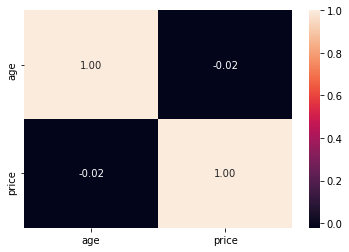

In [18]:
fig = plt.figure()
sns.heatmap(df[['age', 'gender', 'category', 'price']].corr(), annot=True, fmt=".2f")
plt.show()

### Then we need to encode the categorical data to numerical data so that we can train model later

In [19]:
from sklearn.preprocessing import LabelEncoder

In [314]:
l1 = LabelEncoder()
cat = ['category', 'gender']
for parameter in cat:
    l1.fit(df[parameter])
    df[parameter] = l1.transform(df[parameter])

In [315]:
### Transform the float number to integer for model training.

106446

In [21]:
df['age'] = df['age'].astype('int')
df['price'] = df['price'].astype('int')

### Total number of data left after data preprocessing

In [22]:
df.head()

user  gender  age  category  price
8   LHXRgMIvLsJIsBZ9EcE6h8jLWkWboqseR1ftfkTPD/U=       0   22        12    324
17  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12    424
18  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12    424
19  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12     24
20  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12     24

# Dimention Reduction<hr>

In [23]:
df.head()

user  gender  age  category  price
8   LHXRgMIvLsJIsBZ9EcE6h8jLWkWboqseR1ftfkTPD/U=       0   22        12    324
17  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12    424
18  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12    424
19  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12     24
20  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12     24

# Dimention Reduction<hr>
This part is done by Juno: <br>
After the data cleaning, integration and tranforming (filling missing value, detect outlier...), we will perform PCA to see if we can reduce some parameter(s).<br>

### Import library

In [24]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

### Standardize different parameter to do PCA

In [25]:
variables = ['category', 'gender', 'age']
x = df.loc[:, variables].values
y = df.loc[:,['price']].values
x = StandardScaler().fit_transform(x)
x = pd.DataFrame(x)

In [321]:
### Train the PCA model

In [26]:
pca = PCA()
x_pca = pca.fit_transform(x)
x_pca = pd.DataFrame(x_pca)
x_pca.head()

0         1         2
0 -1.569029 -0.217562 -0.956087
1 -0.834100 -0.528874 -0.362232
2 -0.834100 -0.528874 -0.362232
3 -0.834100 -0.528874 -0.362232
4 -0.834100 -0.528874 -0.362232

### From Below, we can see that only two parameter cannot even capture 70% of the variance of the data, therefore we won't conduct any dimention reduction here.

In [27]:
explained_variance = pca.explained_variance_ratio_
explained_variance[:2].sum()

0.6859674795833717

In [28]:
x_pca['price']=y
x_pca.columns = ['category', 'gender', 'age', 'price']
x_pca.head()

category    gender       age  price
0 -1.569029 -0.217562 -0.956087    324
1 -0.834100 -0.528874 -0.362232    424
2 -0.834100 -0.528874 -0.362232    424
3 -0.834100 -0.528874 -0.362232     24
4 -0.834100 -0.528874 -0.362232     24

# Regression<hr>
This part is done by Nathalie:<br>
First, by using the processed data, we split the training dataset and test data set.<br>
After that, we would use the training set to training the multiple linear regression model.<br>
We will then used the model to predict the value by test dataset, and evaluate it with the real value of test dataset.

In [29]:
df.head()

user  gender  age  category  price
8   LHXRgMIvLsJIsBZ9EcE6h8jLWkWboqseR1ftfkTPD/U=       0   22        12    324
17  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12    424
18  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12    424
19  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12     24
20  W5UIVAX8xv2iZFRYSjDEOmX3wcpAEQvU+SW8p7hAFO4=       0   30        12     24

In [326]:
print(len(df))

106446


For 3 predictors (), the equation includes all the possible combinations of different order polynomials. This is known as Multi-dimensional Polynomial Regression.

1. Import all libraries needed

In [30]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
import math
import seaborn as sns

2. Split the dataframe into traing set and test set

In [31]:
X = df[['gender', 'age', 'category']]
Y = df['price']

df = df.sample(frac=1).reset_index(drop=True)# shuffle the data

x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, train_size = .8)
# random_state is a pseudo-random number parameter that allows you to reproduce the same train test split each time you run the code. 

3. Build the Regression Model
   
    3.1. Multiple linear Regression

<h4>
Multiple linear regression: 
When two or more dependent (X) variables are required for a prediction the analysis is referred to as multiple linear regression.

The simple linear regression equation can be adapted to accommodate multiple dependent variables in the following way:
$$Y = a+b_{1}X_{1}+b_{2}X_{2}+b_{3}X_{3}+\cdots +b_{n}X_{n} $$
</h4>

In [33]:
mlr = LinearRegression()
mlr.fit(x_train, y_train)

LinearRegression()

In [34]:
# model equation of multiple linear regression
print("Intercept: " ,mlr.intercept_)
print("Coefficients:")
list(zip(x, mlr.coef_))

Intercept:  998.9020068373145
Coefficients:


[(0, -20.43775600018423), (1, -2.6556650572299922), (2, -12.958818078900979)]

In [35]:
# prediction of test set
y_pred_mlr= mlr.predict(x_test)
print("Prediction for test set: {}".format(y_pred_mlr))

Prediction for test set: [699.14578854 689.34791577 687.06513339 ... 724.57837345 678.3253089
 652.60589287]


 Evaluation of regression model

In [334]:
from sklearn.metrics import mean_squared_error

In [335]:
mse_mlr = mean_squared_error(y_test, y_pred_mlr)
print(mse_mlr)

646558.4436562925


# KNN Tree<hr>
This part is done by Nathalie:<br>
First, by using the processed data, we split the training dataset and test data set.<br>
After that, we would use the training set to training the 3 nearest neighbour classifier.<br>
We will then used the model to predict the value by test dataset, and evaluate it with the real value of test dataset.

In [38]:
from sklearn.neighbors import KNeighborsRegressor

In [39]:
knn_model = KNeighborsRegressor(n_neighbors=3)
knn_model.fit(x_train, y_train)
train_preds = knn_model.predict(x_test)

In [366]:
mse_knn = mean_squared_error(y_test, train_preds)
print(mse_knn)

1371438.2567454726


# Support Vector Machine <hr>
This part is done by Nathalie and Juno:<br>
First, by using the processed data, we split the training dataset and test data set.<br>
After that, we would use the training set to training the SVM Model.<br>
We have test different kernal including linear, polynomial, rbf, and sigmoid<br>
We will then used the model to predict the value by test dataset, and evaluate it with the real value of test dataset for each model.<br>
And choose the best among them.

In [42]:
x_train

gender  age  category
91523        0   30        10
154484       1   35         4
169578       0   39        12
161456       0   35        10
95998        0   50         7
...        ...  ...       ...
34009        1   30        12
76144        1   35        12
71042        1   35        12
72544        0   50         8
113684       0   30        12

[83852 rows x 3 columns]

In [43]:
from sklearn.svm import SVC

### Linear SVM

In [44]:
clf = SVC(kernel = "linear")
clf.fit(x_train[:1000], y_train[:1000])
y_pred_svm = clf.predict(x_test)

In [45]:
mse_SVC1 = mean_squared_error(y_test, y_pred_svm)
print(mse_SVC1)

354087.57274375117


### Polynomial SVM

In [46]:
clf = SVC(kernel = "poly")
clf.fit(x_train[:1000], y_train[:1000])
y_pred_svm = clf.predict(x_test)

In [47]:
mse_SVC2 = mean_squared_error(y_test, y_pred_svm)
print(mse_SVC2)

338325.1943808434


### rbf SVM

In [48]:
clf = SVC(kernel = "rbf")
clf.fit(x_train[:1000], y_train[:1000])
y_pred_svm = clf.predict(x_test)

In [49]:
mse_SVC3 = mean_squared_error(y_test, y_pred_svm)
print(mse_SVC3)

352171.43078610953


### signmoid SVM

In [50]:
clf = SVC(kernel = "sigmoid")
clf.fit(x_train[:1000], y_train[:1000])
y_pred_svm = clf.predict(x_test)

In [51]:
mse_SVC4 = mean_squared_error(y_test, y_pred_svm)
print(mse_SVC4)

387638.0640622019


In [52]:
print(f"linear:{mse_SVC1}, polynomial:{mse_SVC2}, rbf:{mse_SVC3}, signmoid:{mse_SVC4}")

linear:354087.57274375117, polynomial:338325.1943808434, rbf:352171.43078610953, signmoid:387638.0640622019


# Decision Tree <hr>
This part is done by Joseph and Nathalie:<br>
First, by using the processed data, we split the training dataset and test data set.<br>
After that, we would use the training set to training the Decision Model.<br>
We have test different DT Model including entropy and gini one<br>
We will then used the model to predict the value by test dataset, and evaluate it with the real value of test dataset for each model.<br>
And choose the best among them.

In [53]:
df.head()

user  gender  age  category  price
0  5QvTuhoaJ3VWUFbQ56v3Pnfh9LMmcoygHXNbcwhkzxM=       1   60        12    124
1  S2CCzj66cRbs2vNLk2nW6PZOEDWSLRz5BKklTvrSVO4=       0   35        12    324
2  40TWjPbGfaQS2xaJ9dadZKPrpeceRKbOHI8Jx+nPonk=       0   30        12    524
3  /GPG7CXruSpS12PQRMuUd4EowQ8+ADDIG6Z55Mekl+U=       0   35         4    574
4  xTWZE/JQFlO3pXBZWJJU2kPBQoSt9qbjHkeXnp6cPMw=       1   35        12    424

## Thing's to do <br>
<h3><ol>
<li> train test split: Use sklearn library, 80% training 20% test</li>
<li> Model Training</li>
<li> Performance Testing: Use R2 and RMS From HW 5</li>
</ol></h3>

In [352]:
from sklearn.tree import DecisionTreeClassifier

In [381]:
# Create Decision Tree classifer object
clf2 = DecisionTreeClassifier(criterion='entropy',max_leaf_nodes = 3)

# Train Decision Tree Classifer
clf2 = clf2.fit(x_train[:1000],y_train[:1000])

#Predict the response for test dataset
y_pred_dt = clf2.predict(x_test)

Evaluation of model

In [382]:
mse_clf2 = mean_squared_error(y_test, y_pred_dt)
print(mse_clf2)

765283.4957726633


In [383]:
# Create Decision Tree classifer object
clf3 = DecisionTreeClassifier(criterion='gini',max_leaf_nodes = 3)

# Train Decision Tree Classifer
clf3 = clf3.fit(x_train[:1000],y_train[:1000])

#Predict the response for test dataset
y_pred_dt = clf3.predict(x_test)

In [384]:
mse_clf3 = mean_squared_error(y_test, y_pred_dt)
print(mse_clf3)

768668.1834194458


Visualization of decision tree

In [385]:
from sklearn import tree

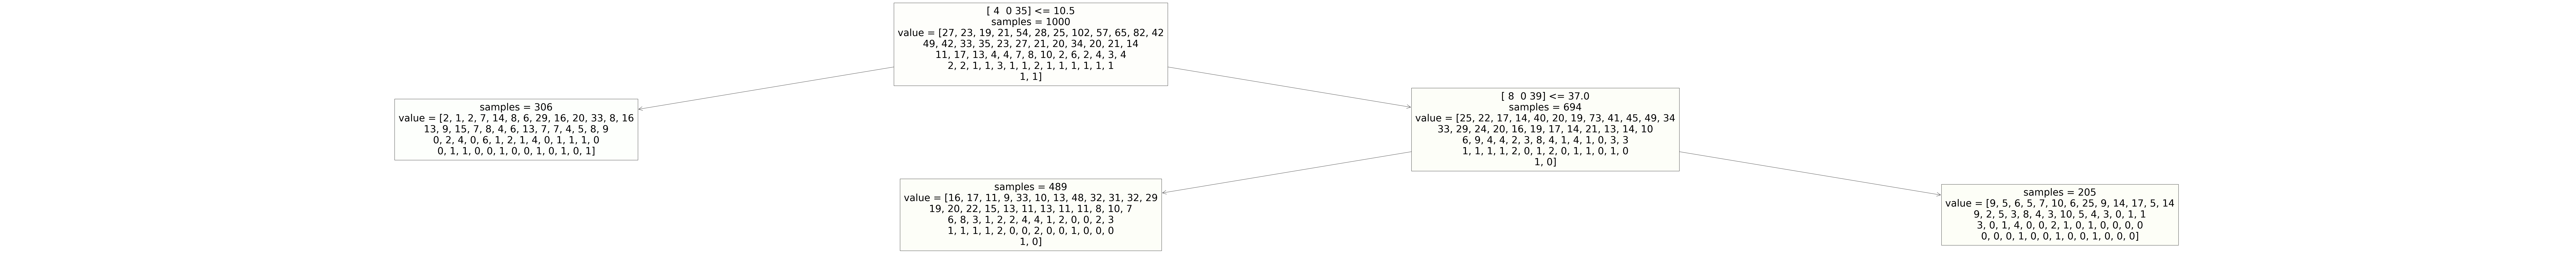

In [386]:
fig = plt.figure(figsize=(200,20))
variables = ['category', 'gender', 'age']
graph = tree.plot_tree(clf2, 
                   feature_names=df.loc[:, variables].values,  
                   class_names=None,
                   filled=True,
                   impurity=False)

# Visuallization (HW4) <hr>

## Thing's to do <br>
<h3><ol>
<li>Visualize the dimention reduction data</li>
<li>Visualize the regression line with data point</li>
</ol></h3>